<a name='1'></a>
# 1 - Exploring the ADE20K Dataset
## Dataset has been divided into Training and Validation
<font color='blue'>
    
    
* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net

In [5]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio
import tensorflow as tf

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)
%matplotlib inline

In [6]:
data_dir = 'data'

In [7]:
!ls data

dataa  dataA  datab  dataB  datac  dataC  datad  dataD	datae  dataE


In [8]:
# Grab all the images available for training

train_images= sorted(tf.io.gfile.glob(str(data_dir) + '/*/*/CameraRGB/*.png'))
print(len(train_images))
train_mask = sorted(tf.io.gfile.glob(str(data_dir) + '/*/*/CameraSeg/*.png'))
print(len(train_mask))

for i in range(5):
    print(train_images[i])
    print(train_mask[i])
    print()

9000
9000
data/dataB/dataB/CameraRGB/02_00_002.png
data/dataB/dataB/CameraSeg/02_00_002.png

data/dataB/dataB/CameraRGB/02_00_003.png
data/dataB/dataB/CameraSeg/02_00_003.png

data/dataB/dataB/CameraRGB/02_00_012.png
data/dataB/dataB/CameraSeg/02_00_012.png

data/dataB/dataB/CameraRGB/02_00_013.png
data/dataB/dataB/CameraSeg/02_00_013.png

data/dataB/dataB/CameraRGB/02_00_022.png
data/dataB/dataB/CameraSeg/02_00_022.png



In [9]:
val_images= train_images[8000:]
val_mask = train_mask[8000:]

train_images = train_images[:8000]
train_mask = train_mask[:8000]

<a name='2'></a>
## 2 - Load and Reshape the Data

### Let us Check out the some of the unmasked and masked images from the dataset:

(600, 800, 3)


Text(0.5, 1.0, 'Segmentation')

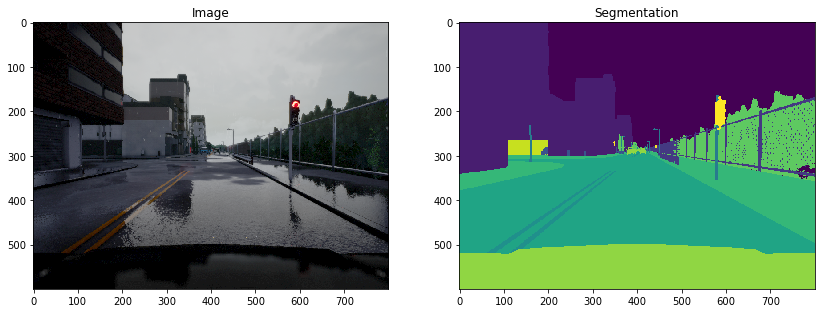

In [10]:
N = 5
img = imageio.imread(train_images[N])
mask = imageio.imread(train_mask[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])
print(img.shape)
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Split Dataset into Unmasked and Masked Images

In [11]:
image_list_ds = tf.data.Dataset.list_files(train_images, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(train_mask, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraRGB/02_00_002.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraSeg/02_00_002.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraRGB/02_00_003.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraSeg/02_00_003.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraRGB/02_00_012.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraSeg/02_00_012.png'>)


In [12]:
val_image_list_ds = tf.data.Dataset.list_files(val_images, shuffle=False)
val_mask_list_ds = tf.data.Dataset.list_files(val_mask, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraRGB/02_00_002.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraSeg/02_00_002.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraRGB/02_00_003.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraSeg/02_00_003.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraRGB/02_00_012.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/dataB/dataB/CameraSeg/02_00_012.png'>)


In [13]:
image_filenames = tf.constant(train_images)
masks_filenames = tf.constant(train_mask)

val_image_filenames = tf.constant(val_images)
val_masks_filenames = tf.constant(val_mask)


train_dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_filenames, val_masks_filenames))

for image, mask in train_dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'data/dataB/dataB/CameraRGB/02_00_002.png', shape=(), dtype=string)
tf.Tensor(b'data/dataB/dataB/CameraSeg/02_00_002.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess The Data

In [14]:
# Define the input Shape
img_height = 240
img_width = 240
num_channels = 3

In [15]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (img_height , img_width), method='nearest')
    input_mask = tf.image.resize(mask, (img_height , img_width), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = train_dataset.map(process_path)
processed_train_ds = image_ds.map(preprocess)

val_image_ds = val_dataset.map(process_path)
processed_val_ds = val_image_ds.map(preprocess)

<a name='3'></a>
## 3 - The U-Net Model


In [16]:
from Model import Model # Import the Model script

In [17]:
model = Model(input_shape = (img_height, img_width, num_channels), n_filters = 32, n_classes = 256, dropout_prob = 0.3)

### Check out the model summary below! 

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 120, 120, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

<a name='3-6'></a>
# 4 - Loss Function and Model Compilation


In [19]:

# Using the Dual GPU available on my desktop
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
with strategy.scope():
    model = tf.keras.models.load_model('t_model.h5')
#     model = Model(input_shape = (img_height, img_width, num_channels), n_filters = 32, n_classes = 256, dropout_prob = 0.3)
#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
#                 loss = tf.keras.losses.sparse_categorical_crossentropy, 
#                  metrics=['accuracy'],)            

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

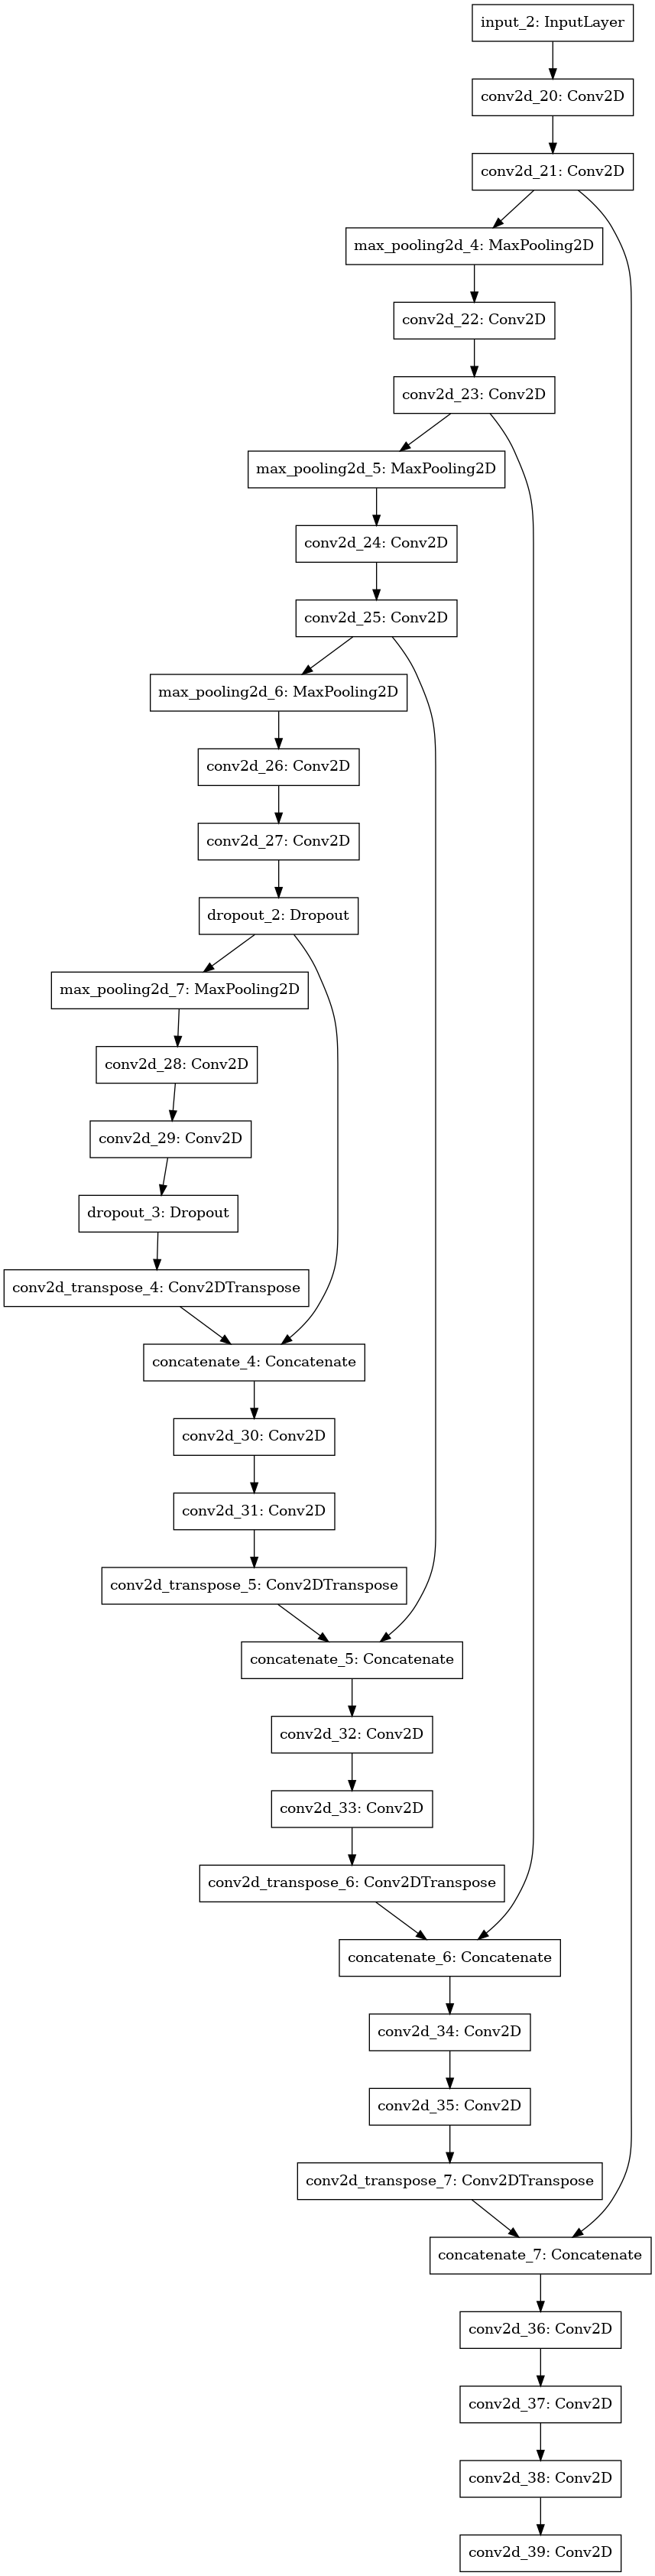

In [20]:
from tensorflow.keras.utils import plot_model 
plot_model(model, to_file='model.png')

<a name='3-7'></a>
### 3.7 - Dataset Handling

function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [39]:
def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.savefig('image.png')
    plt.show()

(600, 800, 3)
(600, 800, 1)


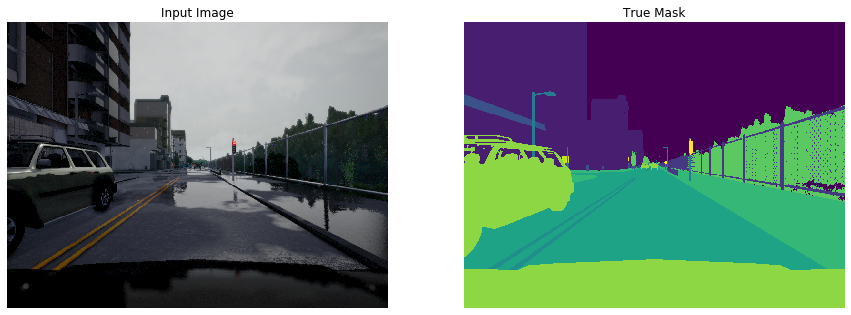

In [26]:
for image, mask in image_ds.take(1):
    print(image.shape)
    print(mask.shape)
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

(240, 240, 1)


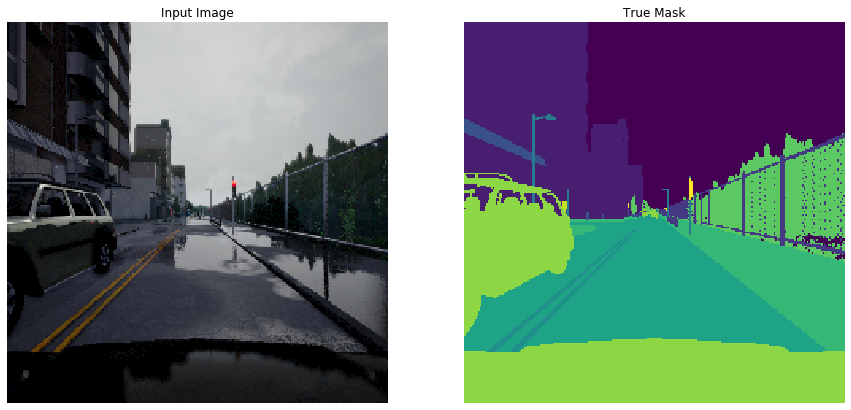

In [27]:
for image, mask in processed_train_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [28]:
print(tf.__version__)

2.4.1


<a name='4'></a>
## 4 - Train the Model

In [29]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 16


processed_train_ds.batch(BATCH_SIZE)
train_dataset = processed_train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
processed_val_ds.batch(BATCH_SIZE)
val_dataset = processed_train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_train_ds.element_spec)
#model_history = model.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(240, 240, 3), dtype=tf.float32, name=None), TensorSpec(shape=(240, 240, 1), dtype=tf.uint8, name=None))


In [30]:
model.save('t_model.h5')


## 4.0 Evaluate Validation Dataset

In [23]:
model.evaluate(val_dataset[0:8]) #

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
500/500 [==============================] - 109s 195ms/step - loss: 0.1708 - accuracy: 0.9511


[0.17077776789665222, 0.9510523676872253]

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [44]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    return pred_mask[0]

In [32]:
tf.test.is_built_with_cuda()

True

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how the model did! 

In [33]:
plt.plot(model_history.history["accuracy"])

NameError: name 'model_history' is not defined

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [45]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image[0:3])
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

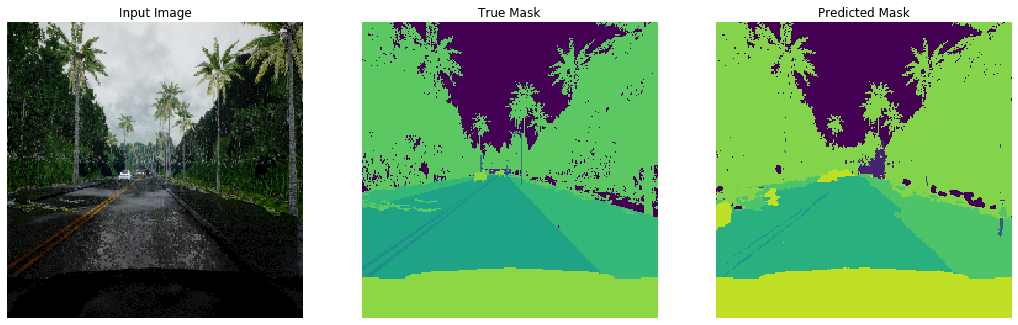

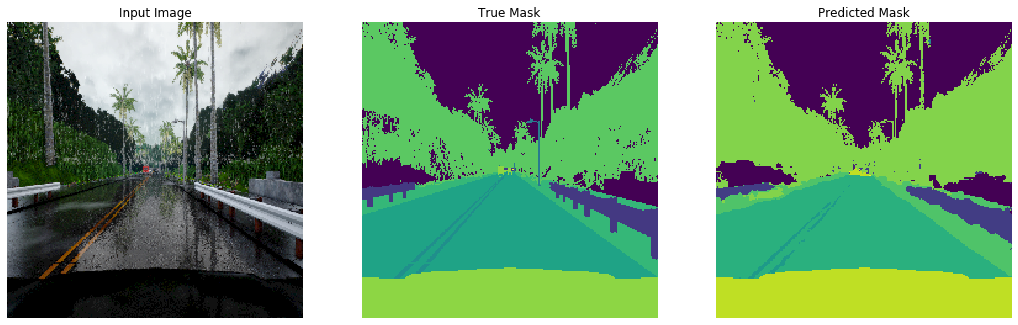

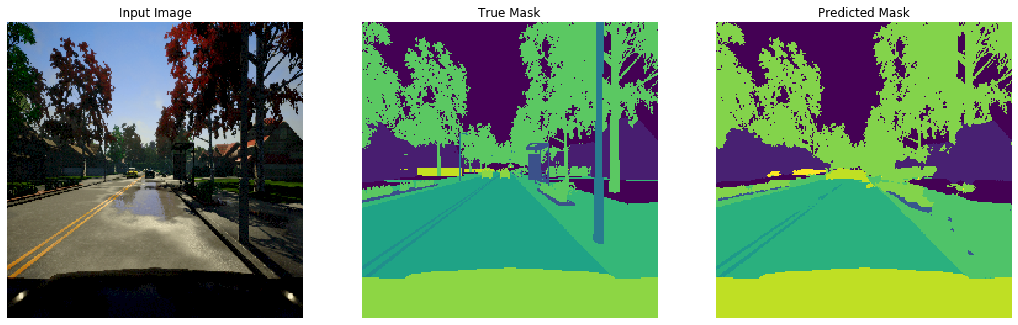

In [46]:
show_predictions(train_dataset, 3)